In [ ]:
#!pip3 install --upgrade pandas

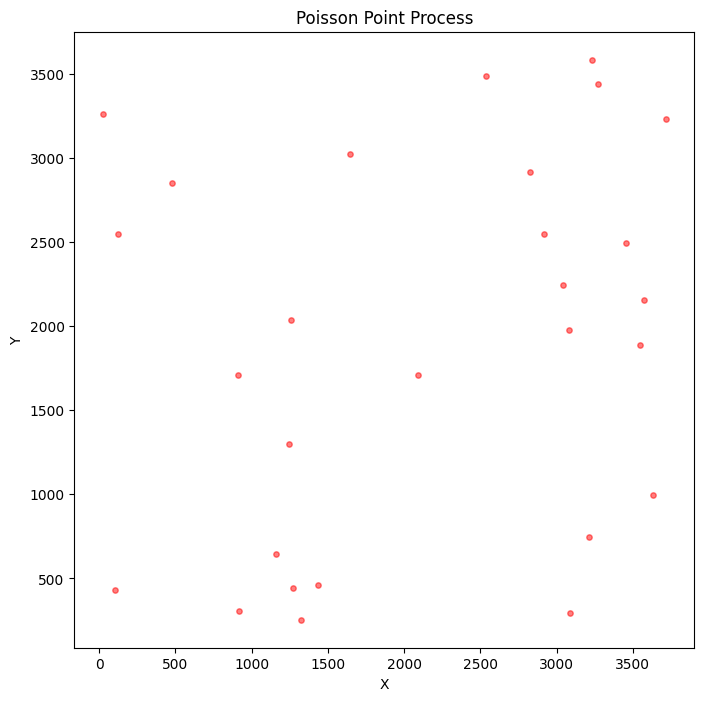

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson
np.random.seed(42)

def poisson_point_process(lam, area, num_points):
    """
    Generates points according to a 2D Poisson Point Process.

    Parameters:
        lam (float): Intensity parameter (average number of points per unit area).
        area (float): Area of the region in which to generate points.
        num_points (int): Number of points to generate.

    Returns:
        numpy.ndarray: Array of shape (num_points, 2) containing generated points.
    """
    num_expected_points = lam * area
    num_generated_points = poisson.rvs(num_expected_points, size=num_points)

    points = np.random.uniform(low=0, high=np.sqrt(area), size=(np.sum(num_generated_points), 2))

    return points[:num_points]

def save_to_csv(filename, points):
    """
    Saves points to a CSV file.

    Parameters:
        filename (str): Name of the CSV file to save.
        points (numpy.ndarray): Array of points to save.
    """
    df = pd.DataFrame(points, columns=['X-coordinate', 'Y-coordinate'])
    df.to_csv(filename, index=False)

def plot_points(points):
    """
    Plots the generated points.

    Parameters:
        points (numpy.ndarray): Array of points to plot.
    """
    plt.figure(figsize=(8, 8))
    plt.scatter(points[:, 0], points[:, 1], s=15, color='red', alpha=0.5)
    plt.title('Poisson Point Process')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

# Parameters
lam = 2e-6  # intensity parameter
area = 16e6  # area of the region
num_points = 28  # number of points

# Generate points
points = poisson_point_process(lam, area, num_points)

# Save to CSV
csv_filename = 'poisson_points.csv'
save_to_csv(csv_filename, points)

# Plot
plot_points(points)


In [ ]:
import math
import csv
import pandas as pd
import numpy as np
from scipy.stats import nakagami
from sklearn.cluster import KMeans

# Constants
frequency = 2e9
c = 3e8
a = 9.16
b = 0.16
attenuation_LoS = 1.0
attenuation_NLoS = 20

# Load TSBS locations from CSV file
def load_tsbs_locations(tsbs_csv):
    tsbs_df = pd.read_csv(tsbs_csv)
    tsbs_df['tsbs_index'] = range(1, len(tsbs_df) + 1)
    return tsbs_df[['tsbs_index', 'X-coordinate', 'Y-coordinate']]

# Generate child UAV locations using K-means clustering
def generate_child_uav_locations(tsbs_df, num_uavs):
    # Perform K-means clustering on TSBS locations to generate child UAV locations
    kmeans = KMeans(n_clusters=num_uavs, random_state=42)
    kmeans.fit(tsbs_df[['X-coordinate', 'Y-coordinate']])
    centroids = kmeans.cluster_centers_

    # Randomly assign altitudes in the range of 300 to 800
    altitudes = np.random.randint(300, 801, size=num_uavs)

    # Create DataFrame for child UAV locations
    child_uav_df = pd.DataFrame({'X-coordinate': centroids[:, 0],
                                 'Y-coordinate': centroids[:, 1],
                                 'altitude': altitudes})

    child_uav_df['uav_index'] = range(1, num_uavs + 1)
    child_uav_csv = 'child_uav_locations_process.csv'
    child_uav_df.to_csv(child_uav_csv, index=False)

    return child_uav_df[['uav_index', 'X-coordinate', 'Y-coordinate', 'altitude']]

# Path loss calculation
def path_loss(distance, elevation_angle):
    wavelength = c / frequency

    # Check if the distance is zero (same location), set LoS probability to 1
    if distance == 0:
        PLoS = 1
    else:
        # Ensure that the argument of math.exp is within a reasonable range
        arg = -b * (elevation_angle - a)

        PLoS = 1 / (1 + a * math.exp(arg))

    PNLoS = 1 - PLoS

    # Ensure the argument of math.log10 is never zero
    if distance == 0:
        path_loss_dB = 0
    else:
        path_loss_dB = (20 * math.log10(4 * math.pi * distance / wavelength)) + PLoS * attenuation_LoS + PNLoS * attenuation_NLoS

    return path_loss_dB, PLoS, PNLoS

# Calculate distance between TSBS and child-UAV
def calculate_distance(tsbs_x, tsbs_y, uav_x, uav_y):
    return math.sqrt((tsbs_x - uav_x) ** 2 + (tsbs_y - uav_y) ** 2)

# Calculate elevation angle between TSBS and child-UAV
def calculate_elevation_angle(distance, altitude):
    return math.atan(altitude / distance)

# Calculate transmit power in dBm from watts
def watts_to_dbm(watts):
    return 10 * math.log10(watts)

# Calculate fading in dB
def calculate_fading(PLoS, PNLoS, m):
    z0 = np.abs(nakagami.rvs(m, size=1))
    z1 = np.abs(nakagami.rvs(m, size=1))
    return PLoS * z0 + PNLoS * z1

# Calculate channel gain in dB
def calculate_channel_gain():
    N = int(1e6)
    fading_coefficients = np.abs((1 / np.sqrt(2)) * (np.random.randn(1, N) + 1j * np.random.randn(1, N)))
    fading_coefficients= fading_coefficients.mean()
    return 10*math.log10(fading_coefficients)

# Load TSBS locations
tsbs_csv = "poisson_points.csv"
tsbs_locations = load_tsbs_locations(tsbs_csv)

# Varying max_bandwidth
for max_bandwidth in range(0, 1001, 100):
    # Generate child UAV locations
    num_uavs = 4 # Number of UAVs equal to the number of TSBS
    child_uav_locations = generate_child_uav_locations(tsbs_locations, num_uavs)

    # Generate random data rate values
    data_rates = np.random.choice([20, 40, 60, 80, 100], size=len(tsbs_locations) * len(child_uav_locations))

    # Calculate path loss, fading, and channel gain for each TSBS-child UAV pair and assign data rate
    channel_gain_data = []
    for idx_tsbs, tsbs_row in tsbs_locations.iterrows():
        for idx_uav, child_uav_row in child_uav_locations.iterrows():
            distance = calculate_distance(tsbs_row['X-coordinate'], tsbs_row['Y-coordinate'],
                                          child_uav_row['X-coordinate'], child_uav_row['Y-coordinate'])
            elevation_angle = calculate_elevation_angle(distance, child_uav_row['altitude'])
            path_loss_dB, PLoS, PNLoS = path_loss(distance, elevation_angle)

            # Calculate fading in dB
            m = 1  # Shape parameter (m = 1 for Rayleigh fading)
            fading_db = watts_to_dbm(calculate_fading(PLoS, PNLoS, m))

            transmit_power_dbm = watts_to_dbm(1.3)  # Transmit power of 1.3 watts converted to dBm
            channel_gain = calculate_channel_gain()
            data_rate = data_rates[idx_tsbs * len(child_uav_locations) + idx_uav]
            channel_gain_data.append(
                (tsbs_row['tsbs_index'], child_uav_row['uav_index'], path_loss_dB, PLoS, PNLoS, channel_gain,
                 data_rate))

    # Save results to CSV
    path_loss_csv = f'path_loss_max_bandwidth_{max_bandwidth}.csv'
    with open(path_loss_csv, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['tsbs_index', 'uav_index', 'path_loss', 'PLoS', 'PNLoS', 'channel_gain', 'data_rate'])
        writer.writerows(channel_gain_data)

    print(f"Completed generation for max_bandwidth = {max_bandwidth}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-9-a4a575d6711d>:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)


Completed generation for max_bandwidth = 0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-9-a4a575d6711d>:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)


Completed generation for max_bandwidth = 100


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-9-a4a575d6711d>:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)


Completed generation for max_bandwidth = 200


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-9-a4a575d6711d>:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)


Completed generation for max_bandwidth = 300


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-9-a4a575d6711d>:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)


Completed generation for max_bandwidth = 400


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-9-a4a575d6711d>:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)


Completed generation for max_bandwidth = 500


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-9-a4a575d6711d>:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)


Completed generation for max_bandwidth = 600


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-9-a4a575d6711d>:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)


Completed generation for max_bandwidth = 700


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-9-a4a575d6711d>:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)


Completed generation for max_bandwidth = 800


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-9-a4a575d6711d>:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)


Completed generation for max_bandwidth = 900


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-9-a4a575d6711d>:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)


Completed generation for max_bandwidth = 1000


In [ ]:
import pandas as pd
import numpy as np
import math

# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Max Bandwidth', 'Sum Rate (F_s)', 'Bandwidth Consumed', 'Number of 1s in A_updated'])

# Iterate over different max_bandwidth values
for max_bandwidth in range(0, 1001, 100):
    # Load the path_loss.csv file for the current max_bandwidth
    path_loss_csv = f'path_loss_max_bandwidth_{max_bandwidth}.csv'
    channel_gain_df = pd.read_csv(path_loss_csv)
    # Calculate the product of magnitude squared of channel gain and inverse of path-loss for each row
    product_column = (channel_gain_df['channel_gain'] ** 2) / (channel_gain_df['path_loss'])

    # Add the product column to the DataFrame
    channel_gain_df['parameter'] = product_column

    # Convert parameter column from dB to watt
    channel_gain_df['parameter'] = 10**(channel_gain_df['parameter'] / 10)

    # Convert interference threshold from watts to dBm
    interference_threshold_dbm = 1.1943**-14  # Convert watts to dBm

    # Calculate optimal power using the division of the 'product' column and interference threshold in dB
    channel_gain_df['optimal_power'] = interference_threshold_dbm / channel_gain_df['parameter']

    def calculate_fading(PLoS, PNLoS, m1,m2):
      z0 = np.abs(nakagami.rvs(m1, size=1))
      z1 = np.abs(nakagami.rvs(m1, size=1))
      z0=10*math.log10(z0)
      z1=10*math.log10(z1)
      return PLoS * z0 + PNLoS * z1

    # Update the calculate_fading function to consider Nakagami distribution
    def calculate_received_power(optimal_power, path_loss, PLoS, PNLoS, m1, m2):
        fading = calculate_fading(PLoS, PNLoS, m1, m2)
        received_power_dB = 10 * np.log10(optimal_power) + fading - path_loss
        # Convert received power from dB to watts
        return received_power_dB

    # Define shape parameter 'm' for Nakagami distribution
    m1 = 1  # For Rayleigh fading, set m = 1
    m2 = 4

    # Calculate received power in watts using the formula
    channel_gain_df['received_power_dB'] = calculate_received_power(channel_gain_df['optimal_power'],
                                                                      channel_gain_df['path_loss'],
                                                                      channel_gain_df['PLoS'],
                                                                      channel_gain_df['PNLoS'],
                                                                      m1, m2)
    noise_power_dbm = -125  # Noise power in dBm

    # Calculate SINR for each row
    def calculate_sinr(received_power, interference_sum, noise_power):
        return received_power / (noise_power + interference_sum)

    # Calculate interference sum for each row (sum of interference powers from other child-UAVs)
    def calculate_interference_sum(channel_gain_df):
        interference_sum = channel_gain_df.groupby(['tsbs_index'])['received_power_dB'].transform('sum') - channel_gain_df['received_power_dB']
        return interference_sum

    # Calculate interference sum column
    channel_gain_df['interference_sum'] = calculate_interference_sum(channel_gain_df)

    # Calculate SINR column
    channel_gain_df['SINR'] = calculate_sinr(channel_gain_df['received_power_dB'], channel_gain_df['interference_sum'], noise_power_dbm)
    # Calculate the bandwidth using the formula: data_rate / log2(1 + SINR)
    bandwidth_column = channel_gain_df['data_rate'] / np.log2(1 + channel_gain_df['SINR'])

    # Add the bandwidth column to the DataFrame
    channel_gain_df['bandwidth'] = bandwidth_column
    spectral_efficiency_column = channel_gain_df['data_rate'] / channel_gain_df['bandwidth']

    # Add the spectral efficiency column to the DataFrame
    channel_gain_df['spectral_efficiency'] = spectral_efficiency_column

    # Save the updated DataFrame to channel_gain.csv
    channel_gain_df.to_csv(path_loss_csv, index=False)


    # Load the data from the CSV file
    df = pd.read_csv(path_loss_csv)

    # Find unique 'sbs_index' and 'uav_index'
    unique_tsbs_index = df['tsbs_index'].unique()
    unique_uav_index = df['uav_index'].unique()

    # Initialize the matrix A with zeros
    A = pd.DataFrame(0, index=unique_tsbs_index, columns=unique_uav_index)

    # Minimum SINR threshold
    min_sinr = -10

    # Iterate over each unique 'sbs_index'
    for tsbs_index in unique_tsbs_index:
        # Filter rows for the current 'sbs_index'
        tsbs_data = df[df['tsbs_index'] == tsbs_index]

        # Find the child-UAV providing maximum SINR
        max_sinr_row = tsbs_data.loc[tsbs_data['SINR'].idxmax()]
        max_sinr_uav_index = max_sinr_row['uav_index']
        max_sinr_value = max_sinr_row['SINR']

        # Check if SINR exceeds the minimum SINR threshold
        if max_sinr_value > min_sinr:
            A.loc[tsbs_index, max_sinr_uav_index] = 1

    # Initialize the matrix A_updated with zeros
    A_updated = A.copy()

    # Initialize counters
    num_links_updated = 0
    C_bandwidth = 0

    max_links = 7

    # Iterate over each child-UAV
    for uav_index in unique_uav_index:
        existing_links = A_updated.index[A_updated[uav_index] == 1]

        # Get data for the current child-UAV
        uav_data = df[df['uav_index'] == uav_index]

        # Initialize counters
        C_bandwidth = 0
        num_links_updated = 0

        # Iterate through TSBSs until maximum resources are utilized
        for tsbs_index in uav_data['tsbs_index'].unique():
            # Filter data for the current tsbs_index and sort by spectral efficiency
            tsbs_data = uav_data[uav_data['tsbs_index'] == tsbs_index]
            tsbs_data = tsbs_data.sort_values(by='spectral_efficiency', ascending=False)

            # Iterate through sorted data
            for _, row in tsbs_data.iterrows():
                bandwidth = row['bandwidth']

                # Check if adding the bandwidth exceeds maximum allowed bandwidth or maximum number of links
                if C_bandwidth + bandwidth <= max_bandwidth and num_links_updated < max_links:
                    # Update matrix A and counters
                    if tsbs_index in existing_links:
                        A_updated.loc[tsbs_index, uav_index] = 1
                        C_bandwidth += bandwidth

                else:
                    # If adding bandwidth exceeds the maximum allowed, break the loop
                    A_updated.loc[tsbs_index, uav_index] = 0
                    break

    # Ensure each column (UAV) has no more than 7 ones (1s)
    for uav_index in unique_uav_index:
        column_sum = A_updated[uav_index].sum()
        if column_sum > max_links:
            # Find indices of extra ones and set them to zero
            extra_indices = A_updated.index[A_updated[uav_index] == 1][max_links:]
            A_updated.loc[extra_indices, uav_index] = 0


    # Calculate sum rate F_s
    F_s = 0
    for tsbs_index in unique_tsbs_index:
        for uav_index in unique_uav_index:
            if A_updated.loc[tsbs_index, uav_index] == 1:
                data_rate = df[(df['tsbs_index'] == tsbs_index) & (df['uav_index'] == uav_index)]['data_rate'].values[0]
                F_s += data_rate

    # Initialize C' as the total number of associated TSBSs
    C_prime = A_updated.sum().sum()

    # Initialize Cb as the cumulative bandwidth used by associated TSBSs
    C_b = (A_updated * df['bandwidth']).sum().sum()

    # Initialize Fs as total sum-rate of associated TSBSs
    Fs = F_s

    # Initialize RB (required bandwidth) as 1.6 Gbps
    RB = 1.6 * 1000  # Convert Gbps to Mbps

    # Continue looping until Fs is less than or equal to RB
    while Fs > RB:
        # Select child-UAV with max associated TSBSs
        max_tsbs_uav = A_updated.sum(axis=0).idxmax()

        # Select TSBS with minimum data rate demand
        min_data_rate_tsbs = df.loc[df['uav_index'] == max_tsbs_uav].sort_values(by='data_rate').iloc[0]
        min_data_rate_tsbs_index = min_data_rate_tsbs['tsbs_index']
        min_data_rate_data_rate = min_data_rate_tsbs['data_rate']

        # De-associate the selected pair and update matrix A, decrement C', update Fs, and decrement Cb
        A_updated.loc[min_data_rate_tsbs_index, max_tsbs_uav] = 0
        C_prime -= 1
        Fs -= min_data_rate_data_rate
        C_b -= min_data_rate_tsbs['bandwidth']

    # Calculate the number of 1s in A_updated
    num_ones = A_updated.values.sum()

    # Append results to the results DataFrame
    results_df.loc[len(results_df)] = {'Max Bandwidth': max_bandwidth,
                                    'Sum Rate (F_s)': F_s,
                                    'Bandwidth Consumed': C_b,
                                    'Number of 1s in A_updated': num_ones}

# Save results to CSV
results_df.to_csv('results_kmeans_ppp.csv', index=False)
print("Results saved to results.csv")


<ipython-input-10-21d3cb48ee31>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z0=10*math.log10(z0)
<ipython-input-10-21d3cb48ee31>:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z1=10*math.log10(z1)
<ipython-input-10-21d3cb48ee31>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z0=10*math.log10(z0)
<ipython-input-10-21d3cb48ee31>:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you ext

Results saved to results.csv


In [ ]:
!pip install scikit-learn-extra
import math
import csv
import pandas as pd
import numpy as np
from scipy.stats import nakagami
from sklearn_extra.cluster import KMedoids  # Import KMedoids for PAM
from sklearn.metrics import pairwise_distances_argmin_min

# Constants
frequency = 2e9
c = 3e8
a = 9.16
b = 0.16
attenuation_LoS = 1.0
attenuation_NLoS = 20

# Load TSBS locations from CSV file
def load_tsbs_locations(tsbs_csv):
    tsbs_df = pd.read_csv(tsbs_csv)
    tsbs_df['tsbs_index'] = range(1, len(tsbs_df) + 1)
    return tsbs_df[['tsbs_index', 'X-coordinate', 'Y-coordinate']]

# Generate child UAV locations using K-medoids clustering (PAM)
def generate_child_uav_locations(tsbs_df, num_uavs):
    # Convert TSBS coordinates to array
    tsbs_coordinates = tsbs_df[['X-coordinate', 'Y-coordinate']].values

    # Initialize K-medoids algorithm
    kmedoids = KMedoids(n_clusters=num_uavs, random_state=42)
    kmedoids.fit(tsbs_coordinates)

    # Get indices of chosen medoids and their coordinates
    medoid_indices = kmedoids.medoid_indices_
    medoid_coordinates = kmedoids.cluster_centers_

    # Randomly assign altitudes in the range of 300 to 800
    altitudes = np.random.randint(300, 801, size=num_uavs)

    # Create DataFrame for child UAV locations
    child_uav_df = pd.DataFrame({'X-coordinate': medoid_coordinates[:, 0],
                                 'Y-coordinate': medoid_coordinates[:, 1],
                                 'altitude': altitudes})

    child_uav_df['uav_index'] = range(1, num_uavs + 1)

    return child_uav_df[['uav_index', 'X-coordinate', 'Y-coordinate', 'altitude']]

# Path loss calculation
def path_loss(distance, elevation_angle):
    wavelength = c / frequency

    # Check if the distance is zero (same location), set LoS probability to 1
    if distance == 0:
        PLoS = 1
    else:
        # Ensure that the argument of math.exp is within a reasonable range
        arg = -b * (elevation_angle - a)

        PLoS = 1 / (1 + a * math.exp(arg))

    PNLoS = 1 - PLoS

    # Ensure the argument of math.log10 is never zero
    if distance == 0:
        path_loss_dB = 0
    else:
        path_loss_dB = (20 * math.log10(4 * math.pi * distance / wavelength)) + PLoS * attenuation_LoS + PNLoS * attenuation_NLoS

    return path_loss_dB, PLoS, PNLoS

# Calculate distance between TSBS and child-UAV
def calculate_distance(tsbs_x, tsbs_y, uav_x, uav_y):
    return math.sqrt((tsbs_x - uav_x) ** 2 + (tsbs_y - uav_y) ** 2)

# Calculate elevation angle between TSBS and child-UAV
def calculate_elevation_angle(distance, altitude):
    return math.atan(altitude / distance)

# Calculate transmit power in dBm from watts
def watts_to_dbm(watts):
    return 10 * math.log10(watts)

# Calculate fading in dB
def calculate_fading(PLoS, PNLoS, m):
    z0 = np.abs(nakagami.rvs(m, size=1))
    z1 = np.abs(nakagami.rvs(m, size=1))
    return PLoS * z0 + PNLoS * z1

# Calculate channel gain in dB
def calculate_channel_gain():
    N = int(1e6)
    fading_coefficients = np.abs((1 / np.sqrt(2)) * (np.random.randn(1, N) + 1j * np.random.randn(1, N)))
    fading_coefficients= fading_coefficients.mean()
    return 10*math.log10(fading_coefficients)

# Load TSBS locations
tsbs_csv = "poisson_points.csv"
tsbs_locations = load_tsbs_locations(tsbs_csv)

# Varying max_bandwidth
for max_bandwidth in range(0, 1001, 100):
    # Generate child UAV locations
    num_uavs = 4  # Number of UAVs equal to the number of TSBS
    child_uav_locations = generate_child_uav_locations(tsbs_locations, num_uavs)

    # Generate random data rate values
    data_rates = np.random.choice([20, 40, 60, 80, 100], size=len(tsbs_locations) * len(child_uav_locations))

    # Calculate path loss, fading, and channel gain for each TSBS-child UAV pair and assign data rate
    channel_gain_data = []
    tsbs_to_skip = set()  # To store tsbs_index with path_loss = 0
    for idx_tsbs, tsbs_row in tsbs_locations.iterrows():
        tsbs_path_loss_zero = False  # Flag to track if path_loss is zero for this tsbs_index
        for idx_uav, child_uav_row in child_uav_locations.iterrows():
            distance = calculate_distance(tsbs_row['X-coordinate'], tsbs_row['Y-coordinate'],
                                          child_uav_row['X-coordinate'], child_uav_row['Y-coordinate'])
            elevation_angle = calculate_elevation_angle(distance, child_uav_row['altitude'])
            path_loss_dB, PLoS, PNLoS = path_loss(distance, elevation_angle)

            # Check if path_loss is zero
            if path_loss_dB == 0:
                tsbs_path_loss_zero = True
                break  # No need to continue calculating for this tsbs_index

            # Calculate fading in dB
            m = 1  # Shape parameter (m = 1 for Rayleigh fading)
            fading_db = watts_to_dbm(calculate_fading(PLoS, PNLoS, m))

            transmit_power_dbm = watts_to_dbm(1.3)  # Transmit power of 1.3 watts converted to dBm
            channel_gain = calculate_channel_gain()
            data_rate = data_rates[idx_tsbs * len(child_uav_locations) + idx_uav]
            channel_gain_data.append(
                (tsbs_row['tsbs_index'], child_uav_row['uav_index'], path_loss_dB, PLoS, PNLoS, channel_gain,
                 data_rate))

        # If path_loss is zero for any UAV of this TSBS, mark tsbs_index for skipping
        if tsbs_path_loss_zero:
            tsbs_to_skip.add(tsbs_row['tsbs_index'])

    # Filter out data for tsbs_index with path_loss = 0
    channel_gain_data_filtered = [(tsbs_idx, uav_idx, path_loss, PLoS, PNLoS, ch_gain, data_rate)
                                  for tsbs_idx, uav_idx, path_loss, PLoS, PNLoS, ch_gain, data_rate in channel_gain_data
                                  if tsbs_idx not in tsbs_to_skip]

    # Save results to CSV
    path_loss_csv = f'path_loss_max_bandwidth_{max_bandwidth}.csv'
    with open(path_loss_csv, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['tsbs_index', 'uav_index', 'path_loss', 'PLoS', 'PNLoS', 'channel_gain', 'data_rate'])
        writer.writerows(channel_gain_data_filtered)

    print(f"Completed generation for max_bandwidth = {max_bandwidth}")


<ipython-input-11-ad379f4e7c76>:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-11-ad379f4e7c76>:78: RuntimeWarning: divide by zero encountered in scalar divide
  return math.atan(altitude / distance)


Completed generation for max_bandwidth = 0


<ipython-input-11-ad379f4e7c76>:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-11-ad379f4e7c76>:78: RuntimeWarning: divide by zero encountered in scalar divide
  return math.atan(altitude / distance)


Completed generation for max_bandwidth = 100


<ipython-input-11-ad379f4e7c76>:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-11-ad379f4e7c76>:78: RuntimeWarning: divide by zero encountered in scalar divide
  return math.atan(altitude / distance)


Completed generation for max_bandwidth = 200


<ipython-input-11-ad379f4e7c76>:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-11-ad379f4e7c76>:78: RuntimeWarning: divide by zero encountered in scalar divide
  return math.atan(altitude / distance)


Completed generation for max_bandwidth = 300


<ipython-input-11-ad379f4e7c76>:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-11-ad379f4e7c76>:78: RuntimeWarning: divide by zero encountered in scalar divide
  return math.atan(altitude / distance)


Completed generation for max_bandwidth = 400


<ipython-input-11-ad379f4e7c76>:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-11-ad379f4e7c76>:78: RuntimeWarning: divide by zero encountered in scalar divide
  return math.atan(altitude / distance)


Completed generation for max_bandwidth = 500


<ipython-input-11-ad379f4e7c76>:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-11-ad379f4e7c76>:78: RuntimeWarning: divide by zero encountered in scalar divide
  return math.atan(altitude / distance)


Completed generation for max_bandwidth = 600


<ipython-input-11-ad379f4e7c76>:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-11-ad379f4e7c76>:78: RuntimeWarning: divide by zero encountered in scalar divide
  return math.atan(altitude / distance)


Completed generation for max_bandwidth = 700


<ipython-input-11-ad379f4e7c76>:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-11-ad379f4e7c76>:78: RuntimeWarning: divide by zero encountered in scalar divide
  return math.atan(altitude / distance)


Completed generation for max_bandwidth = 800


<ipython-input-11-ad379f4e7c76>:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-11-ad379f4e7c76>:78: RuntimeWarning: divide by zero encountered in scalar divide
  return math.atan(altitude / distance)


Completed generation for max_bandwidth = 900


<ipython-input-11-ad379f4e7c76>:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-11-ad379f4e7c76>:78: RuntimeWarning: divide by zero encountered in scalar divide
  return math.atan(altitude / distance)


Completed generation for max_bandwidth = 1000


In [ ]:
import pandas as pd
import numpy as np

# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Max Bandwidth', 'Sum Rate (F_s)', 'Bandwidth Consumed', 'Number of 1s in A_updated'])

# Iterate over different max_bandwidth values
for max_bandwidth in range(0, 1001, 100):
    # Load the path_loss.csv file for the current max_bandwidth
    path_loss_csv = f'path_loss_max_bandwidth_{max_bandwidth}.csv'
    channel_gain_df = pd.read_csv(path_loss_csv)
    # Calculate the product of magnitude squared of channel gain and inverse of path-loss for each row
    product_column = (channel_gain_df['channel_gain'] ** 2) / (channel_gain_df['path_loss'])

    # Add the product column to the DataFrame
    channel_gain_df['parameter'] = product_column

    # Convert parameter column from dB to watt
    channel_gain_df['parameter'] = 10**(channel_gain_df['parameter'] / 10)

    # Convert interference threshold from watts to dBm
    interference_threshold_dbm = 1.1943**-14  # Convert watts to dBm

    # Calculate optimal power using the division of the 'product' column and interference threshold in dB
    channel_gain_df['optimal_power'] = interference_threshold_dbm / channel_gain_df['parameter']

    def calculate_fading(PLoS, PNLoS, m1,m2):
      z0 = np.abs(nakagami.rvs(m1, size=1))
      z1 = np.abs(nakagami.rvs(m1, size=1))
      z0=10*math.log10(z0)
      z1=10*math.log10(z1)
      return PLoS * z0 + PNLoS * z1

    # Update the calculate_fading function to consider Nakagami distribution
    def calculate_received_power(optimal_power, path_loss, PLoS, PNLoS, m1, m2):
        fading = calculate_fading(PLoS, PNLoS, m1, m2)
        received_power_dB = 10 * np.log10(optimal_power) + fading - path_loss
        # Convert received power from dB to watts
        return received_power_dB

    # Define shape parameter 'm' for Nakagami distribution
    m1 = 1  # For Rayleigh fading, set m = 1
    m2 = 4

    # Calculate received power in watts using the formula
    channel_gain_df['received_power_dB'] = calculate_received_power(channel_gain_df['optimal_power'],
                                                                      channel_gain_df['path_loss'],
                                                                      channel_gain_df['PLoS'],
                                                                      channel_gain_df['PNLoS'],
                                                                      m1, m2)
    noise_power_dbm = -125  # Noise power in dBm

    # Calculate SINR for each row
    def calculate_sinr(received_power, interference_sum, noise_power):
        return received_power / (noise_power + interference_sum)

    # Calculate interference sum for each row (sum of interference powers from other child-UAVs)
    def calculate_interference_sum(channel_gain_df):
        interference_sum = channel_gain_df.groupby(['tsbs_index'])['received_power_dB'].transform('sum') - channel_gain_df['received_power_dB']
        return interference_sum

    # Calculate interference sum column
    channel_gain_df['interference_sum'] = calculate_interference_sum(channel_gain_df)

    # Calculate SINR column
    channel_gain_df['SINR'] = calculate_sinr(channel_gain_df['received_power_dB'], channel_gain_df['interference_sum'], noise_power_dbm)
    # Calculate the bandwidth using the formula: data_rate / log2(1 + SINR)
    bandwidth_column = channel_gain_df['data_rate'] / np.log2(1 + channel_gain_df['SINR'])

    # Add the bandwidth column to the DataFrame
    channel_gain_df['bandwidth'] = bandwidth_column
    spectral_efficiency_column = channel_gain_df['data_rate'] / channel_gain_df['bandwidth']

    # Add the spectral efficiency column to the DataFrame
    channel_gain_df['spectral_efficiency'] = spectral_efficiency_column

    # Save the updated DataFrame to channel_gain.csv
    channel_gain_df.to_csv(path_loss_csv, index=False)


    # Load the data from the CSV file
    df = pd.read_csv(path_loss_csv)

    # Find unique 'sbs_index' and 'uav_index'
    unique_tsbs_index = df['tsbs_index'].unique()
    unique_uav_index = df['uav_index'].unique()

    # Initialize the matrix A with zeros
    A = pd.DataFrame(0, index=unique_tsbs_index, columns=unique_uav_index)

    # Minimum SINR threshold
    min_sinr = -10

    # Iterate over each unique 'sbs_index'
    for tsbs_index in unique_tsbs_index:
        # Filter rows for the current 'sbs_index'
        tsbs_data = df[df['tsbs_index'] == tsbs_index]

        # Find the child-UAV providing maximum SINR
        max_sinr_row = tsbs_data.loc[tsbs_data['SINR'].idxmax()]
        max_sinr_uav_index = max_sinr_row['uav_index']
        max_sinr_value = max_sinr_row['SINR']

        # Check if SINR exceeds the minimum SINR threshold
        if max_sinr_value > min_sinr:
            A.loc[tsbs_index, max_sinr_uav_index] = 1

    # Initialize the matrix A_updated with zeros
    A_updated = A.copy()

    # Initialize counters
    num_links_updated = 0
    C_bandwidth = 0

    max_links = 7

    # Iterate over each child-UAV
    for uav_index in unique_uav_index:
        existing_links = A_updated.index[A_updated[uav_index] == 1]

        # Get data for the current child-UAV
        uav_data = df[df['uav_index'] == uav_index]

        # Initialize counters
        C_bandwidth = 0
        num_links_updated = 0

        # Iterate through TSBSs until maximum resources are utilized
        for tsbs_index in uav_data['tsbs_index'].unique():
            # Filter data for the current tsbs_index and sort by spectral efficiency
            tsbs_data = uav_data[uav_data['tsbs_index'] == tsbs_index]
            tsbs_data = tsbs_data.sort_values(by='spectral_efficiency', ascending=False)

            # Iterate through sorted data
            for _, row in tsbs_data.iterrows():
                bandwidth = row['bandwidth']

                # Check if adding the bandwidth exceeds maximum allowed bandwidth or maximum number of links
                if C_bandwidth + bandwidth <= max_bandwidth and num_links_updated < max_links:
                    # Update matrix A and counters
                    if tsbs_index in existing_links:
                        A_updated.loc[tsbs_index, uav_index] = 1
                        C_bandwidth += bandwidth

                else:
                    # If adding bandwidth exceeds the maximum allowed, break the loop
                    A_updated.loc[tsbs_index, uav_index] = 0
                    break

    # Ensure each column (UAV) has no more than 7 ones (1s)
    for uav_index in unique_uav_index:
        column_sum = A_updated[uav_index].sum()
        if column_sum > max_links:
            # Find indices of extra ones and set them to zero
            extra_indices = A_updated.index[A_updated[uav_index] == 1][max_links:]
            A_updated.loc[extra_indices, uav_index] = 0


    # Calculate sum rate F_s
    F_s = 0
    for tsbs_index in unique_tsbs_index:
        for uav_index in unique_uav_index:
            if A_updated.loc[tsbs_index, uav_index] == 1:
                data_rate = df[(df['tsbs_index'] == tsbs_index) & (df['uav_index'] == uav_index)]['data_rate'].values[0]
                F_s += data_rate

    # Initialize C' as the total number of associated TSBSs
    C_prime = A_updated.sum().sum()

    # Initialize Cb as the cumulative bandwidth used by associated TSBSs
    C_b = (A_updated * df['bandwidth']).sum().sum()

    # Initialize Fs as total sum-rate of associated TSBSs
    Fs = F_s

    # Initialize RB (required bandwidth) as 1.6 Gbps
    RB = 1.6 * 1000  # Convert Gbps to Mbps

    # Continue looping until Fs is less than or equal to RB
    while Fs > RB:
        # Select child-UAV with max associated TSBSs
        max_tsbs_uav = A_updated.sum(axis=0).idxmax()

        # Select TSBS with minimum data rate demand
        min_data_rate_tsbs = df.loc[df['uav_index'] == max_tsbs_uav].sort_values(by='data_rate').iloc[0]
        min_data_rate_tsbs_index = min_data_rate_tsbs['tsbs_index']
        min_data_rate_data_rate = min_data_rate_tsbs['data_rate']

        # De-associate the selected pair and update matrix A, decrement C', update Fs, and decrement Cb
        A_updated.loc[min_data_rate_tsbs_index, max_tsbs_uav] = 0
        C_prime -= 1
        Fs -= min_data_rate_data_rate
        C_b -= min_data_rate_tsbs['bandwidth']

    # Calculate the number of 1s in A_updated
    num_ones = A_updated.values.sum()

    # Append results to the results DataFrame
    results_df.loc[len(results_df)] = {'Max Bandwidth': max_bandwidth,
                                    'Sum Rate (F_s)': F_s,
                                    'Bandwidth Consumed': C_b,
                                    'Number of 1s in A_updated': num_ones}
# Save results to CSV
results_df.to_csv('results_medoids_ppp.csv', index=False)
print("Results saved to results.csv")


<ipython-input-12-7dfb2cf71241>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z0=10*math.log10(z0)
<ipython-input-12-7dfb2cf71241>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z1=10*math.log10(z1)
<ipython-input-12-7dfb2cf71241>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z0=10*math.log10(z0)
<ipython-input-12-7dfb2cf71241>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you ext

Results saved to results.csv


In [ ]:
import numpy as np
import os

# Define parameters
S = 50  # Total population size
U = 4   # Total number of child UAVs
min_altitude = 300
max_altitude = 800
min_coordinate = 0
max_coordinate = 4000

# Initialize population
population = []

# Generate S chromosomes
for _ in range(S):
    # Initialize a chromosome representing location details of child UAVs
    chromosome = np.zeros((U, 3))  # U rows, 3 columns (x, y, h)

    # Generate random location details for each child UAV
    for i in range(U):
        # Random x-coordinate
        x = np.random.uniform(min_coordinate, max_coordinate)

        # Random y-coordinate
        y = np.random.uniform(min_coordinate, max_coordinate)

        # Random altitude
        h = np.random.randint(min_altitude, max_altitude + 1)

        # Assign location details to chromosome
        chromosome[i] = [x, y, h]

    # Add chromosome to the population
    population.append(chromosome)

# Convert population to NumPy array
population = np.array(population)

# Save each chromosome separately
for i, chromosome in enumerate(population):
    # Define the filename for the chromosome
    filename = f"chromosome_{i+1}.csv"

    # Save chromosome to CSV file
    np.savetxt(filename, chromosome, delimiter=",", header="X-coordinate,Y-coordinate,altitude", comments="")

# Print the first chromosome to verify the structure
print("Sample chromosome:")
print(population[0])


Sample chromosome:
[[2637.41568882 3580.47096283  499.        ]
 [ 907.85877746 3557.56366452  642.        ]
 [2073.63208778  600.67600327  715.        ]
 [3953.101084   1773.09234977  307.        ]]


In [ ]:
import math
import csv
import pandas as pd
import numpy as np
from scipy.stats import nakagami

# Constants
frequency = 2e9
c = 3e8
a = 9.16
b = 0.16
attenuation_LoS = 1.0
attenuation_NLoS = 20

# Load TSBS and child UAV locations from CSV files
def load_tsbs_locations(tsbs_csv):
    tsbs_df = pd.read_csv(tsbs_csv)
    tsbs_df['tsbs_index'] = range(1, len(tsbs_df) + 1)
    return tsbs_df[['tsbs_index', 'X-coordinate', 'Y-coordinate']]



# Path loss calculation
def path_loss(distance, elevation_angle):
    wavelength = c / frequency

    # Check if the distance is zero (same location), set LoS probability to 1
    if distance == 0:
        PLoS = 1
    else:
        # Ensure that the argument of math.exp is within a reasonable range
        arg = -b * (elevation_angle - a)

        PLoS = 1 / (1 + a * math.exp(arg))

    PNLoS = 1 - PLoS

    # Ensure the argument of math.log10 is never zero
    if distance == 0:
        path_loss_dB = 0
    else:
        path_loss_dB = (20 * math.log10(4 * math.pi * distance / wavelength)) + PLoS * attenuation_LoS  + PNLoS * attenuation_NLoS

    return path_loss_dB, PLoS, PNLoS

# Calculate distance between TSBS and child-UAV
def calculate_distance(tsbs_x, tsbs_y, uav_x, uav_y):
    return math.sqrt((tsbs_x - uav_x)**2 + (tsbs_y - uav_y)**2)

# Calculate elevation angle between TSBS and child-UAV
def calculate_elevation_angle(distance, altitude):
    return math.atan(altitude / distance)

# Calculate transmit power in dBm from watts
def watts_to_dbm(watts):
    return 10 * math.log10(watts)

# Calculate fading in dB
def calculate_fading(PLoS, PNLoS, m):
    z0 = np.abs(nakagami.rvs(m, size=1))
    z1 = np.abs(nakagami.rvs(m, size=1))
    return PLoS * z0 + PNLoS * z1

# Calculate channel gain in dB
def calculate_channel_gain():
    N = int(1e6)
    fading_coefficients = np.abs((1/np.sqrt(2)) * (np.random.randn(1, N) + 1j*np.random.randn(1, N)))
    fading_coefficients= fading_coefficients.mean()
    return 10*math.log10(fading_coefficients)

# Calculate received power in dBm from watts
def received_power_dbm(optimal_power, path_loss, PLoS, PNLoS, m):
    fading = calculate_fading(PLoS, PNLoS, m)
    return 10 * np.log10(optimal_power) + fading - path_loss

# Calculate SINR
def calculate_sinr(received_power, interference_sum, noise_power_dbm):
    return received_power / (noise_power_dbm + interference_sum)

# Calculate interference sum
def calculate_interference_sum(channel_gain_df):
    interference_sum = channel_gain_df.groupby(['tsbs_index'])['received_power_dB'].transform('sum') - channel_gain_df['received_power_dB']
    return interference_sum

# Calculate bandwidth
def calculate_bandwidth(data_rate, sinr):
    return data_rate / np.log2(1 + sinr)

# Calculate spectral efficiency
def calculate_spectral_efficiency(data_rate, bandwidth):
    return data_rate / bandwidth

# Function to calculate all parameters and optimize allocation for each chromosome
def calculate_parameters_and_optimize(chromosome):
    # Load child UAV locations from chromosome file
    child_uav_locations = pd.read_csv(chromosome)

    # Add a unique uav_index to the child UAV locations
    child_uav_locations['uav_index'] = range(1, len(child_uav_locations) + 1)

    # Load TSBS locations
    tsbs_csv = "poisson_points.csv"
    tsbs_locations = load_tsbs_locations(tsbs_csv)

    # Generate random data rate values
    data_rates = np.random.choice([20, 40, 60, 80, 100], size=len(tsbs_locations) * len(child_uav_locations))

    # Calculate path loss, fading, and channel gain for each TSBS-child UAV pair and assign data rate
    channel_gain_data = []
    for idx_tsbs, tsbs_row in tsbs_locations.iterrows():
        for idx_uav, child_uav_row in child_uav_locations.iterrows():
            distance = calculate_distance(tsbs_row['X-coordinate'], tsbs_row['Y-coordinate'], child_uav_row['X-coordinate'], child_uav_row['Y-coordinate'])
            elevation_angle = calculate_elevation_angle(distance, child_uav_row['altitude'])
            path_loss_dB, PLoS, PNLoS = path_loss(distance, elevation_angle)

            # Calculate fading in dB
            m = 1  # Shape parameter (m = 1 for Rayleigh fading)
            fading_db = watts_to_dbm(calculate_fading(PLoS, PNLoS, m))

            transmit_power_dbm = watts_to_dbm(1.3)  # Transmit power of 1.3 watts converted to dBm
            channel_gain = calculate_channel_gain()
            data_rate = data_rates[idx_tsbs * len(child_uav_locations) + idx_uav]
            channel_gain_data.append((tsbs_row['tsbs_index'], child_uav_row['uav_index'], path_loss_dB, PLoS, PNLoS, channel_gain, data_rate))

    # Save results to DataFrame
    channel_gain_df = pd.DataFrame(channel_gain_data, columns=['tsbs_index', 'uav_index', 'path_loss', 'PLoS', 'PNLoS', 'channel_gain', 'data_rate'])

    # Calculate received power in dBm
    m = 1  # Shape parameter (m = 1 for Rayleigh fading)
    channel_gain_df['received_power_dB'] = received_power_dbm(1.3, channel_gain_df['path_loss'], channel_gain_df['PLoS'], channel_gain_df['PNLoS'], m)

    # Calculate SINR
    noise_power_dbm = -125  # Noise power in dBm
    channel_gain_df['interference_sum'] = calculate_interference_sum(channel_gain_df)
    channel_gain_df['SINR'] = calculate_sinr(channel_gain_df['received_power_dB'], channel_gain_df['interference_sum'], noise_power_dbm)

    # Calculate bandwidth
    channel_gain_df['bandwidth'] = calculate_bandwidth(channel_gain_df['data_rate'], channel_gain_df['SINR'])

    # Calculate spectral efficiency
    channel_gain_df['spectral_efficiency'] = calculate_spectral_efficiency(channel_gain_df['data_rate'], channel_gain_df['bandwidth'])

    channel_gain_df.to_csv("path_loss.csv", index=False)


    # Load the data from the CSV file
    df = pd.read_csv("path_loss.csv")

    # Find unique 'sbs_index' and 'uav_index'
    unique_tsbs_index = df['tsbs_index'].unique()
    unique_uav_index = df['uav_index'].unique()

    # Initialize the matrix A with zeros
    A = pd.DataFrame(0, index=unique_tsbs_index, columns=unique_uav_index)

    # Minimum SINR threshold
    min_sinr = -10

    # Iterate over each unique 'sbs_index'
    for tsbs_index in unique_tsbs_index:
        # Filter rows for the current 'sbs_index'
        tsbs_data = df[df['tsbs_index'] == tsbs_index]

        # Find the child-UAV providing maximum SINR
        max_sinr_row = tsbs_data.loc[tsbs_data['SINR'].idxmax()]
        max_sinr_uav_index = max_sinr_row['uav_index']
        max_sinr_value = max_sinr_row['SINR']

        # Check if SINR exceeds the minimum SINR threshold
        if max_sinr_value > min_sinr:
            A.loc[tsbs_index, max_sinr_uav_index] = 1

    # Initialize the matrix A_updated with zeros
    A_updated = A.copy()

    # Initialize counters
    num_links_updated = 0
    C_bandwidth = 0
    max_bandwidth=900
    max_links = 7

    # Iterate over each child-UAV
    for uav_index in unique_uav_index:
        existing_links = A_updated.index[A_updated[uav_index] == 1]

        # Get data for the current child-UAV
        uav_data = df[df['uav_index'] == uav_index]

        # Initialize counters
        C_bandwidth = 0
        num_links_updated = 0

        # Iterate through TSBSs until maximum resources are utilized
        for tsbs_index in uav_data['tsbs_index'].unique():
            # Filter data for the current tsbs_index and sort by spectral efficiency
            tsbs_data = uav_data[uav_data['tsbs_index'] == tsbs_index]
            tsbs_data = tsbs_data.sort_values(by='spectral_efficiency', ascending=False)

            # Iterate through sorted data
            for _, row in tsbs_data.iterrows():
                bandwidth = row['bandwidth']

                # Check if adding the bandwidth exceeds maximum allowed bandwidth or maximum number of links
                if C_bandwidth + bandwidth <= max_bandwidth and num_links_updated < max_links:
                    # Update matrix A and counters
                    if tsbs_index in existing_links:
                        A_updated.loc[tsbs_index, uav_index] = 1
                        C_bandwidth += bandwidth

                else:
                    # If adding bandwidth exceeds the maximum allowed, break the loop
                    A_updated.loc[tsbs_index, uav_index] = 0
                    break

    # Ensure each column (UAV) has no more than 7 ones (1s)
    for uav_index in unique_uav_index:
        column_sum = A_updated[uav_index].sum()
        if column_sum > max_links:
            # Find indices of extra ones and set them to zero
            extra_indices = A_updated.index[A_updated[uav_index] == 1][max_links:]
            A_updated.loc[extra_indices, uav_index] = 0


    # Calculate sum rate F_s
    F_s = 0
    for tsbs_index in unique_tsbs_index:
        for uav_index in unique_uav_index:
            if A_updated.loc[tsbs_index, uav_index] == 1:
                data_rate = df[(df['tsbs_index'] == tsbs_index) & (df['uav_index'] == uav_index)]['data_rate'].values[0]
                F_s += data_rate

    C_prime = A_updated.sum().sum()

    # Initialize Cb as the cumulative bandwidth used by associated TSBSs
    C_b = (A_updated * df['bandwidth']).sum().sum()

    # Initialize Fs as total sum-rate of associated TSBSs
    Fs = F_s

    # Initialize RB (required bandwidth) as 1.6 Gbps
    RB = 1.6 * 1000  # Convert Gbps to Mbps

    # Continue looping until Fs is less than or equal to RB
    while Fs > RB:
        # Select child-UAV with max associated TSBSs
        max_tsbs_uav = A_updated.sum(axis=0).idxmax()

        # Select TSBS with minimum data rate demand
        min_data_rate_tsbs = df.loc[df['uav_index'] == max_tsbs_uav].sort_values(by='data_rate').iloc[0]
        min_data_rate_tsbs_index = min_data_rate_tsbs['tsbs_index']
        min_data_rate_data_rate = min_data_rate_tsbs['data_rate']

        # De-associate the selected pair and update matrix A, decrement C', update Fs, and decrement Cb
        A_updated.loc[min_data_rate_tsbs_index, max_tsbs_uav] = 0
        C_prime -= 1
        Fs -= min_data_rate_data_rate
        C_b -= min_data_rate_tsbs['bandwidth']


    #A_updated = pd.DataFrame(index=tsbs_locations['tsbs_index'], columns=child_uav_locations['uav_index'])
    num_ones = A_updated.values.sum()



    # Return the number of chromosome, sum rate F_s, and number of 1s in the A_updated matrix
    return chromosome, F_s, num_ones

# Main loop to process each chromosome
results = []
for chromosome_num in range(1,51):
    chromosome_file = f"chromosome_{chromosome_num}.csv"
    chromosome, F_s, num_ones = calculate_parameters_and_optimize(chromosome_file)
    results.append((chromosome, F_s, num_ones))

# Save results to a CSV file
results_df = pd.DataFrame(results, columns=['Chromosome', 'Sum_Rate_F_s', 'Number_of_Ones_in_A_updated'])
results_df.to_csv("optimization_results.csv", index=False)

print("Optimization completed for all chromosomes. Results saved to optimization_results.csv.")


<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will erro

Optimization completed for all chromosomes. Results saved to optimization_results.csv.


In [ ]:
import pandas as pd

# Load optimization_results.csv
results_df = pd.read_csv("optimization_results.csv")

# Sort the DataFrame in descending order of Sum_Rate_F_s and Number_of_Ones_in_A_updated
sorted_results_df = results_df.sort_values(by=['Sum_Rate_F_s', 'Number_of_Ones_in_A_updated'], ascending=False)

# Save the sorted DataFrame to a new CSV file
sorted_results_df.to_csv("optimization_results.csv", index=False)


In [ ]:
import pandas as pd
import numpy as np

# Load the optimization_results.csv file
results_df = pd.read_csv("optimization_results.csv")

# Define fitness function (you need to define your own fitness function)
def fitness_function(row):
    # Example fitness function: Sum of sum rate and number of ones
    return row['Sum_Rate_F_s']

# Calculate fitness values
results_df['Fitness'] = results_df.apply(fitness_function, axis=1)

# Sort the DataFrame by fitness in descending order
sorted_results_df = results_df.sort_values(by='Fitness', ascending=False)

# Calculate the number of elite parents (40% of total chromosomes)
num_elite_parents = int(0.4 * len(sorted_results_df))

# Select elite parents
elite_parents = sorted_results_df.head(num_elite_parents)
elite_parents=elite_parents['Chromosome']

# Perform roulette wheel selection for the remaining chromosomes
remaining_chromosomes = sorted_results_df.tail(len(sorted_results_df) - num_elite_parents)

# Calculate probabilities for RWS
total_fitness = remaining_chromosomes['Fitness'].sum()
remaining_chromosomes['Probability'] = remaining_chromosomes['Fitness'] / total_fitness

# Perform RWS to select remaining chromosomes
selected_indices = np.random.choice(remaining_chromosomes.index, size=len(remaining_chromosomes), replace=True, p=remaining_chromosomes['Probability'])
selected_chromosomes = remaining_chromosomes.loc[selected_indices]
selected_chromosomes=selected_chromosomes['Chromosome']


<ipython-input-35-ca4abe19e35e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_chromosomes['Probability'] = remaining_chromosomes['Fitness'] / total_fitness


In [ ]:
import pandas as pd
import numpy as np
import random

# Mutation parameters
mutation_rate = 0.09
gmtd_value = 4

# Function to apply mutation to a single chromosome
def apply_mutation(chromosome_file):
    # Load the chromosome file
    df = pd.read_csv(chromosome_file)

    # Get the total number of child UAVs in the chromosome
    num_child_uavs = len(df)

    # Calculate the number of child UAVs to mutate based on mutation rate
    num_to_mutate = int(round(mutation_rate * num_child_uavs))

    # Select random child UAVs to mutate
    indices_to_mutate = random.sample(range(num_child_uavs), num_to_mutate)

    # Iterate over selected indices and apply mutation
    for idx in indices_to_mutate:
        # Coin toss to decide whether to add or subtract gmtd_value
        if random.random() < 0.5:
            # Add gmtd_value
            df.loc[idx, 'X-coordinate'] += gmtd_value
        else:
            # Subtract gmtd_value
            df.loc[idx, 'X-coordinate'] -= gmtd_value

        # Similarly mutate Y-coordinate and altitude
        if random.random() < 0.5:
            df.loc[idx, 'Y-coordinate'] += gmtd_value
        else:
            df.loc[idx, 'Y-coordinate'] -= gmtd_value

        if random.random() < 0.5:
            df.loc[idx, 'altitude'] += gmtd_value
        else:
            df.loc[idx, 'altitude'] -= gmtd_value

    # Save the mutated chromosome to the same file
    df.to_csv(chromosome_file, index=False)

    return chromosome_file

# List of selected chromosome files obtained from roulette wheel selection
selected_chromosomes
# Apply mutation to each selected chromosome file
mutated_files = []
for chromosome_file in selected_chromosomes:
    mutated_file = apply_mutation(chromosome_file)
    mutated_files.append(mutated_file)

print("Mutation applied to selected chromosomes.")


Mutation applied to selected chromosomes.


In [ ]:
selected_chromosomes_files=pd.concat([elite_parents, selected_chromosomes])
selected_chromosomes_files.head()

0    chromosome_29.csv
1     chromosome_1.csv
2     chromosome_3.csv
3    chromosome_15.csv
4    chromosome_22.csv
Name: Chromosome, dtype: object

In [ ]:
results = []
for chromosome_file in selected_chromosomes_files:
    chromosome, F_s, num_ones = calculate_parameters_and_optimize(chromosome_file)
    results.append((chromosome, F_s, num_ones))

# Save results to a CSV file
results_df = pd.DataFrame(results, columns=['Chromosome', 'Sum_Rate_F_s', 'Number_of_Ones_in_A_updated'])
results_df.to_csv("optimization_results.csv", index=False)

<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will erro

In [ ]:
import pandas as pd
import numpy as np
import random

# Function to apply mutation to a single chromosome
def apply_mutation(chromosome_file):
    # Load the chromosome file
    df = pd.read_csv(chromosome_file)

    # Get the total number of child UAVs in the chromosome
    num_child_uavs = len(df)

    # Calculate the number of child UAVs to mutate based on mutation rate
    num_to_mutate = int(round(mutation_rate * num_child_uavs))

    # Select random child UAVs to mutate
    indices_to_mutate = random.sample(range(num_child_uavs), num_to_mutate)

    # Iterate over selected indices and apply mutation
    for idx in indices_to_mutate:
        # Coin toss to decide whether to add or subtract gmtd_value
        if random.random() < 0.5:
            # Add gmtd_value
            df.loc[idx, 'X-coordinate'] += gmtd_value
        else:
            # Subtract gmtd_value
            df.loc[idx, 'X-coordinate'] -= gmtd_value

        # Similarly mutate Y-coordinate and altitude
        if random.random() < 0.5:
            df.loc[idx, 'Y-coordinate'] += gmtd_value
        else:
            df.loc[idx, 'Y-coordinate'] -= gmtd_value

        if random.random() < 0.5:
            df.loc[idx, 'altitude'] += gmtd_value
        else:
            df.loc[idx, 'altitude'] -= gmtd_value

    # Save the mutated chromosome to the same file
    df.to_csv(chromosome_file, index=False)

    return chromosome_file

# Perform iteration
top_sum_rate = None
unchanged_iterations = 0
for _ in range(10):  # 50 iterations
    # Load optimization_results.csv
    results_df = pd.read_csv("optimization_results.csv")

    # Sort the DataFrame in descending order of Sum_Rate_F_s and Number_of_Ones_in_A_updated
    sorted_results_df = results_df.sort_values(by=['Sum_Rate_F_s', 'Number_of_Ones_in_A_updated'], ascending=False)

    # Save the sorted DataFrame to a new CSV file
    sorted_results_df.to_csv("optimization_results.csv", index=False)

    # Load the optimization_results.csv file
    results_df = pd.read_csv("optimization_results.csv")

    # Define fitness function
    def fitness_function(row):
        return row['Sum_Rate_F_s']

    # Calculate fitness values
    results_df['Fitness'] = results_df.apply(fitness_function, axis=1)

    # Sort the DataFrame by fitness in descending order
    sorted_results_df = results_df.sort_values(by='Fitness', ascending=False)

    # Calculate the number of elite parents (40% of total chromosomes)
    num_elite_parents = int(0.4 * len(sorted_results_df))

    # Select elite parents
    elite_parents = sorted_results_df.head(num_elite_parents)
    elite_parents = elite_parents['Chromosome']

    # Perform roulette wheel selection for the remaining chromosomes
    remaining_chromosomes = sorted_results_df.tail(len(sorted_results_df) - num_elite_parents)

    # Calculate probabilities for RWS
    total_fitness = remaining_chromosomes['Fitness'].sum()
    remaining_chromosomes['Probability'] = remaining_chromosomes['Fitness'] / total_fitness

    # Perform RWS to select remaining chromosomes
    selected_indices = np.random.choice(remaining_chromosomes.index, size=len(remaining_chromosomes), replace=True, p=remaining_chromosomes['Probability'])
    selected_chromosomes = remaining_chromosomes.loc[selected_indices]
    selected_chromosomes = selected_chromosomes['Chromosome']

    # Combine elite parents and selected chromosomes
    selected_chromosomes_files = pd.concat([elite_parents, selected_chromosomes])

    # Apply mutation to each selected chromosome file
    mutated_files = []
    for chromosome_file in selected_chromosomes_files:
        mutated_file = apply_mutation(chromosome_file)
        mutated_files.append(mutated_file)

    print(f"Iteration {_+1}: Mutation applied to selected chromosomes.")

    # Run optimization on mutated chromosomes and update optimization_results.csv
    results = []
    for chromosome_file in selected_chromosomes_files:
        chromosome, F_s, num_ones = calculate_parameters_and_optimize(chromosome_file)
        results.append((chromosome, F_s, num_ones))

    # Save results to a CSV file
    results_df = pd.DataFrame(results, columns=['Chromosome', 'Sum_Rate_F_s', 'Number_of_Ones_in_A_updated'])
    results_df.to_csv("optimization_results.csv", index=False)

    # Check if the top sum rate has changed
    current_top_sum_rate = results_df['Sum_Rate_F_s'].max()
    if top_sum_rate is None:
        top_sum_rate = current_top_sum_rate
    elif current_top_sum_rate == top_sum_rate:
        unchanged_iterations += 1
    else:
        top_sum_rate = current_top_sum_rate
        unchanged_iterations = 0

    # If the top sum rate has remained unchanged for 5 iterations, break the loop
    if unchanged_iterations == 5:
        print("Top sum rate has remained unchanged for 5 iterations. Exiting...")
        break

# Print the final top chromosome file and its parameters
final_top_chromosome = results_df.loc[results_df['Sum_Rate_F_s'].idxmax()]
print("Final Top Chromosome:")
print(final_top_chromosome)

# Read and print the final top chromosome file
final_top_chromosome_file = final_top_chromosome['Chromosome']
final_top_chromosome_data = pd.read_csv(final_top_chromosome_file)
final_top_chromosome_file = final_top_chromosome[['Chromosome','Sum_Rate_F_s']]
print("\nFinal Top Chromosome Data:")
print(final_top_chromosome_data)
max_bandwidth=500
final_top_chromosome_file['bandwidth'] = max_bandwidth

# Create a CSV file containing the chromosome, its sum rate, and the maximum bandwidth
final_top_chromosome_file.to_csv("final_top_chromosome_file.csv", index=False)

<ipython-input-39-706e16d44668>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_chromosomes['Probability'] = remaining_chromosomes['Fitness'] / total_fitness
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)


Iteration 1: Mutation applied to selected chromosomes.


<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will erro

Iteration 2: Mutation applied to selected chromosomes.


<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will erro

Iteration 3: Mutation applied to selected chromosomes.


<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will erro

Iteration 4: Mutation applied to selected chromosomes.


<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will erro

Iteration 5: Mutation applied to selected chromosomes.


<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will erro

Iteration 6: Mutation applied to selected chromosomes.


<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will erro

Iteration 7: Mutation applied to selected chromosomes.


<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will erro

Iteration 8: Mutation applied to selected chromosomes.


<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will erro

Iteration 9: Mutation applied to selected chromosomes.


<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will erro

Iteration 10: Mutation applied to selected chromosomes.


<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 10 * math.log10(watts)
<ipython-input-33-c3655bc8e76c>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will erro

Final Top Chromosome:
Chromosome                     chromosome_15.csv
Sum_Rate_F_s                                1120
Number_of_Ones_in_A_updated                   17
Name: 0, dtype: object

Final Top Chromosome Data:
   X-coordinate  Y-coordinate  altitude
0   3176.789325    371.962559     418.0
1   3497.049882   2040.438850     302.0
2    259.414378   2319.935150     354.0
3   2811.773764    211.215842     323.0
